# Verification results notebook
This notebook is meant to perform some statistical analysis on the csv reports from the `verification.py` script. Performing the data analysis on a separate notebook allows me to:
  * decouple data creation from analysis
  * having a persistent storage for plots

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../out.csv')

In [2]:
# preprocessing function, temporary
def remove_prefix(s: str):
    return s.split('.')[-1]

for column_name in ['algorithm', 'backend', 'device', 'dtype']:
    df[column_name] = df[column_name].apply(remove_prefix)

df.head()

,algorithm,name,backend,device,dtype,key,abs_err,total_time
0,RS,rs,NUMPY,CPU,fp64,7871734211187709741,0.000000e+00,0.466063
1,RS,rs_no_complex,NUMPY,CPU,fp64,7871734211187709741,4.440892e-16,0.403272
2,RS,rs,JAX,CPU,fp64,7871734211187709741,2.269629e-12,0.224953
3,RS,rs_no_complex,JAX,CPU,fp64,7871734211187709741,2.269629e-12,0.290229
4,RS,rs_vmap,JAX,CPU,fp64,7871734211187709741,2.393419e-12,0.204246


## CPU section
We consider only CPU implementations. There are many questions to be asked:
  * what is the distribution of the error, among the backends and among the single implementations?
  * are there any outliers in the error?
  * what is the fastest implementation for every backend?
  * can you plot the absolute and relative performance of all the implementations?

### Errors

In [3]:
local = df[
    (df['device'] == 'CPU') &
    (df['abs_err'] > 0) &
    (df['dtype'] == 'fp64')
]

backend_error_map = {
    backend: group['abs_err'].to_numpy()
    for backend, group in local.groupby('backend')
}

for backend, error in backend_error_map.items():
    assert(error.size > 0)

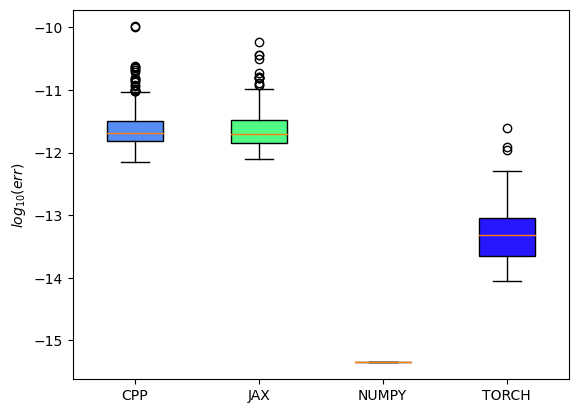

In [4]:
backend_color_map = {
    'NUMPY': '#568df5',
    'JAX': '#52fa85',
    'TORCH': '#fa6b52',
    'CPP': '#2617ff'
}

fig, ax = plt.subplots()
ax.set_ylabel('$log_{10}(err)$')

bplot = ax.boxplot(
    [np.log10(err) for err in backend_error_map.values()],
    patch_artist=True,
    labels=backend_error_map.keys()
)

for patch, color in zip(bplot['boxes'], backend_color_map.values()):
    patch.set_facecolor(color)

plt.show()

The numpy implementation was the reference in this experiment, so it's normal that its absolute error is the lowest. The other implementations could have introduced errors by:
  * calling lower precision variants of trigonometric functions
  * implementing a different reduction strategy for the plus operator

The phase is uniformely distributed in $[0, 2 \pi]$ so this kind of errors don't scare me. This is primarely a test for buggy implementations.

In [5]:
# test for faulty implementations we need to be extremely precise about the:
#   * name of the implementation
#   * backend
#   * seed of the faulty experiment
#
# since I'm not expecting this section to be very much used, I'll just print the faulty rows
faulty_impls_data = df[df['abs_err'] > 1e-9]

if len(faulty_impls_data) > 0:
    print('Validation error: there are experiments with an high absolute error')
    faulty_impls_data.head()
    raise RuntimeError
else:
    print('Validation complete')


Validation complete


### Performance
The data campaign doesn't specifically test for performance as it will be very wasteful to profile a known bad implementation. From this data we can screen for the best implementation in each category, then we can inform more accurate test pipelines.

In [6]:
local = df[
    (df['algorithm'] == 'RS') &
    (df['device'] == 'CPU') &
    (df['dtype'] == 'fp64')
]

In [7]:
# I need a dictionary that pairs (backend, name) as keys
# this is because there are implementations in different backends
# with the same name
#
# I could do a dictionary of dictionaries because I don't really need
# to index by name, I need to index by backend first and then by name
backend_nested_map = {}

for backend, _df in local.groupby('backend'):
    backend_nested_map[backend] = {}

    for name, _ddf in _df.groupby('name'):
        backend_nested_map[backend][name] = _ddf['total_time'].to_numpy()

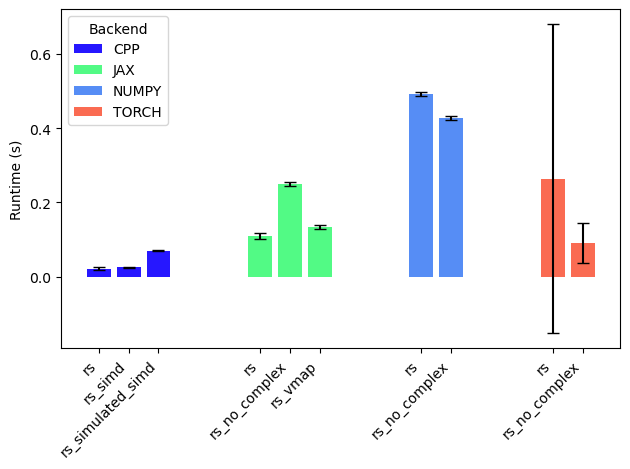

In [8]:
fix, ax = plt.subplots()

# plotting parameters, for decoration
bar_width = 0.2
intra_gap = 0.05
group_gap = 0.6

offset = 0.0
x_positions = []
x_labels = []

for backend, nested_map in backend_nested_map.items():
    for name, t in nested_map.items():
        mean = np.mean(t)
        std = np.std(t)

        ax.bar(
            offset,
            mean,
            bar_width,
            yerr=std,
            color=backend_color_map[backend],
            capsize=4,
            label=backend
        )

        x_positions.append(offset)
        x_labels.append(name)
        offset += bar_width + intra_gap

    offset += group_gap

ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, rotation=45, ha="right")

ax.set_ylabel("Runtime (s)")
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Backend")

plt.tight_layout()
plt.show()

The big variability in the torch version of `rs` is due to:
  * JIT compilation
  * torch non fully supporting complex numbers operations

I think that JAX implementations could still be improved by properly setting up multicore execution.